# Women’s Clothing E-Commerce Reviews 
(real commercial data)

About the data: 
https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/home

Questions:
1) The top 20 best selling clothing. 

2) The effect of age on the cloth selling and reviews? 

3) WordCloud from the reviews. 

4) Sentiment & Recommendation Analysis. 


In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [2]:
from wordcloud import WordCloud
import string
import clothing_functions
#import importlib
#importlib.reload(clothing_functions)
from clothing_functions import *

In [3]:
data = pd.read_csv('Womens Clothing E-Commerce Reviews.csv',index_col=False)
numeric_features = data.select_dtypes(include=[np.number])
categorical_features = data.select_dtypes(include=[np.object])
data.tail(2)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses
23485,23485,1104,52,Please make more like this one!,This dress in a lovely platinum is feminine an...,5,1,22,General Petite,Dresses,Dresses


In [4]:
#data.columns
print('Clothing ID (unique)',len(data['Clothing ID'].unique()))
print('Total size of data',data.shape)

Clothing ID (unique) 1206
Total size of data (23486, 11)


The total num of rows of the data is 23486 on 1206 unique clothings. 

### EDA: fill the missing data, outlier removal, and check the collinearity.   

In [5]:
pd.isnull(data).sum()

Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

A lot of NaNs in the Title and Review Columns.  

Fill the missing Division, Department, Class Name based on Clothing ID. 

In [6]:
#Fill the missing data by looking at the other same key words clothes 
data_clean=data.drop(columns=['Unnamed: 0'])

for row in [136, 72, 152, 184]:
    data_clean[data['Clothing ID'] == row ]=\
    data_clean[data['Clothing ID'] == row].fillna({'Division Name':'Initmates',\
    'Department Name':'Initmate','Class Name':'Legwear'})


data_clean[data['Clothing ID'] == 492]=data_clean[data['Clothing ID'] == 492].fillna({'Division Name':'Initmates',\
                                         'Department Name':'Initmate','Class Name':'Lounge'})
data_clean[data['Clothing ID'] == 772]=data_clean[data['Clothing ID'] == 772].fillna({'Division Name':'General',\
                                         'Department Name':'Tops','Class Name':'Knits'})
data_clean[data['Clothing ID'] == 665 ]=data_clean[data['Clothing ID'] == 665].fillna({'Division Name':'Initmates',\
                                         'Department Name':'Initmate','Class Name':'Intimates'})

In [7]:
data_clean['Title']=data['Title'].fillna('None')
data_clean['Review Text']=data['Review Text'].fillna('None')

In [8]:
# create a new feature Text Length
data_clean['Text Length'] = data_clean['Review Text'].str.split().apply(len)
# creat a new feature Positively Rated 

In [9]:
data_clean.head(2)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Text Length
0,767,33,None,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,8
1,1080,34,None,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,62


In [10]:
data_clean['Age'].describe()

count    23486.000000
mean        43.198544
std         12.279544
min         18.000000
25%         34.000000
50%         41.000000
75%         52.000000
max         99.000000
Name: Age, dtype: float64

In [11]:
outlier=outliers(data_clean['Age'])
data_clean['Age']=data_clean['Age'].mask(outlier['lower'],data_clean['Age'].quantile(0.05)) 
data_clean['Age']=data_clean['Age'].mask(outlier['higher'],data_clean['Age'].quantile(0.95)) 

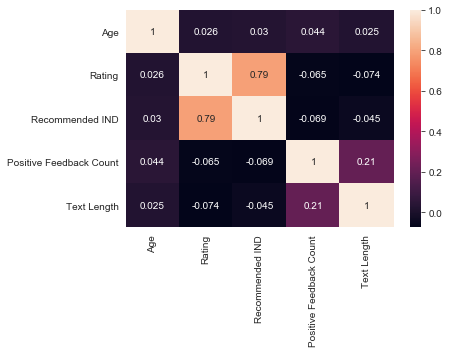

In [12]:
# numeric columns
#sb.pairplot(data[["Clothing ID","Age", "Rating","Recommended IND"]],size = 2 ,kind ='scatter',diag_kind='kde')
data_nms=data_clean[["Age", "Rating","Recommended IND",'Positive Feedback Count',\
               'Text Length']]
sns.heatmap(data_nms.corr(),annot=True) 

### Plots

Rating
1    0.035851
2    0.066635
3    0.122243
4    0.216171
5    0.559099
Name: Age, dtype: float64

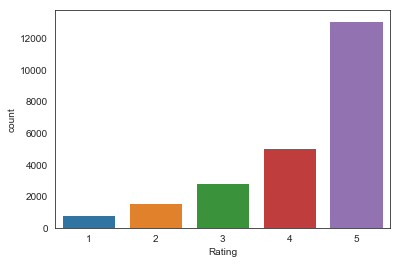

In [13]:
# Rating 
g=sns.countplot(x='Rating',data=data_clean)
data_clean.groupby(['Rating']).count().Age/len(data_clean['Rating'])

In [14]:
data_clean.groupby(['Recommended IND']).count().Age/len(data_clean['Recommended IND'])

Recommended IND
0    0.177638
1    0.822362
Name: Age, dtype: float64

55.9% of rating is 5, 82% of IND is recommened, very good

Rating and recommended is correlated. Therefore, recommended IND and positively rated also correlated. use 3 as a division.

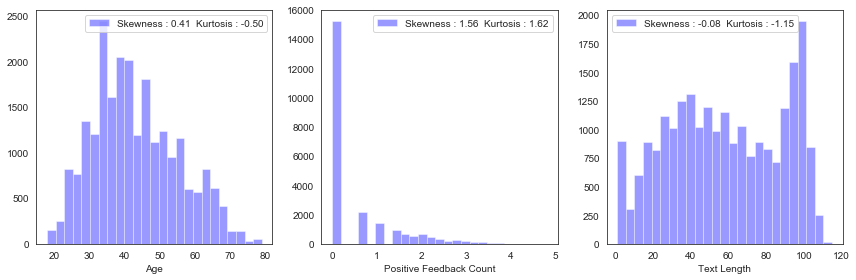

In [15]:
f, ax = plt.subplots(1, 3, figsize=(12, 4))
# age of customers 
plot_dist(data_clean,"Age",ax=ax[0])
# positive feedback count log10()

#plot_dist(data_clean,"Positive Feedback Count",ax=ax[1])
pfc=(data_clean["Positive Feedback Count"].map(lambda i: np.log(i) if i > 0 else 0))
sns.distplot(pfc, \
               color="b", label="Skewness : %.2f  Kurtosis : %.2f"\
                %((pfc).skew(), (pfc).kurt() ),bins=25,ax=ax[1],kde=False)
ax[1].legend(loc="best")
plt.tight_layout()
# text length
plot_dist(data_clean,"Text Length",ax=ax[2])

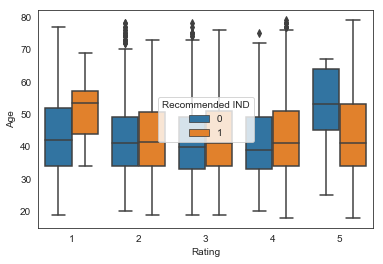

In [16]:
#f, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(x='Rating',y='Age',data=data_clean,hue='Recommended IND')
#sns.barplot(x='Positively Rated',y='Positive Feedback Count',data=data_clean,ax=ax[1])

It seems Age does not affect the rating very much. But we do notice that even in rating 1, some people still recommend
the product (16 cases) while in rating 5, still no recommendation (25 cases). Saved two data frames. And these two cases, age of customers is about 50, older than the normal case. (maybe they are confused with the system?) 

In [17]:
r1_recom=data_clean[(data_clean['Rating'] == 1) & (data_clean['Recommended IND'] == 1)]
r5_no_recom=data_clean[(data_clean['Rating'] == 5) & (data_clean['Recommended IND'] == 0)]

Now we have some understanding of the data. 
Does Age affect the rating/recommendation? 

### ANOVA Test of Age and Rating -- No！Age in two groups not normal distribution. 

In [18]:
import scipy.stats as stats
data_clean['Age'].groupby(data_clean['Recommended IND']).describe()

,count,mean,std,min,25%,50%,75%,max
Recommended IND,,,,,,,,
0,4172.0,42.324784,11.597139,19.0,34.0,40.0,50.0,78.0
1,19314.0,43.277156,12.128541,18.0,34.0,41.0,52.0,79.0


In [19]:
stats.levene(data_clean['Age'][data_clean['Recommended IND'] == 1], 
               data_clean['Age'][data_clean['Recommended IND'] == 0])

LeveneResult(statistic=19.915846251287142, pvalue=8.130284675723641e-06)

In [20]:
stats.f_oneway(data_clean['Age'][data_clean['Recommended IND'] == 1], 
               data_clean['Age'][data_clean['Recommended IND'] == 0])

F_onewayResult(statistic=21.48155691758033, pvalue=3.5916771238679216e-06)

In [21]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
results = ols('Age ~ C(Rating)', data=data[['Age','Rating']]).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     10.40
Date:                Tue, 09 Oct 2018   Prob (F-statistic):           2.04e-08
Time:                        14:09:54   Log-Likelihood:                -92205.
No. Observations:               23486   AIC:                         1.844e+05
Df Residuals:                   23481   BIC:                         1.845e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         43.6936      0.423    103.333      0.000      42.865      44.522
C(Rating)[T.2]    -1.0712      0.524     -2.043      0.041      -2.099      -0.043
C(Rating)[T.3]    -1.5351      0.481     -3.192      0.001      -2.478      -0.593
C(Rating)[T.4]    -0.8061      0.457     -1.765      0.077      -1.701       0.089
C(Rating)[T.5]    -0.1105      0.436     -0.253      0.800      -0.965       0.744
==============================================================================
Omnibus:                      954.129   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1070.194
Skew:                           0.520   Prob(JB):                    4.08e-233
Kurtosis:                       2.885   Cond. No.                         14.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Division Department Class

In [22]:
print(data_clean['Division Name'].unique())
print(data_clean['Department Name'].unique())
print(data_clean['Class Name'].unique())

['Initmates' 'General' 'General Petite']
['Intimate' 'Dresses' 'Bottoms' 'Tops' 'Jackets' 'Trend' 'Initmate']
['Intimates' 'Dresses' 'Pants' 'Blouses' 'Knits' 'Outerwear' 'Lounge'
 'Sweaters' 'Skirts' 'Fine gauge' 'Sleep' 'Jackets' 'Swim' 'Trend' 'Jeans'
 'Legwear' 'Shorts' 'Layering' 'Casual bottoms' 'Chemises']


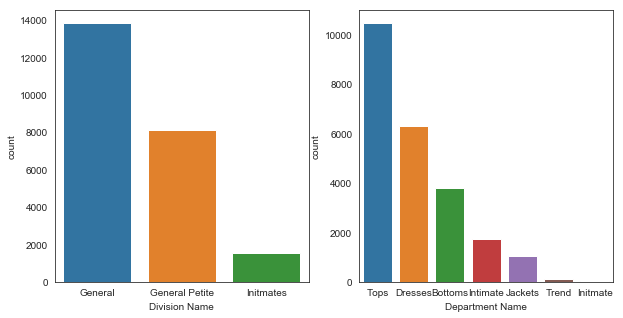

In [23]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x='Division Name',data=data_clean,ax=ax[0],order=data_clean['Division Name'].value_counts().index)
sns.countplot(x='Department Name',data=data_clean,ax=ax[1],order=data_clean['Department Name'].value_counts().index)

General sells more. 

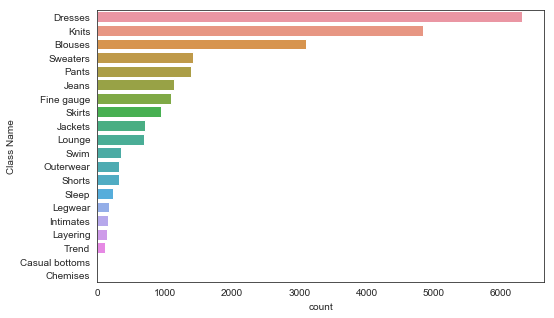

In [24]:
plt.subplots(figsize=(8, 5))
sns.countplot(y='Class Name', data=data_clean,order=data_clean['Class Name'].value_counts().index)

In [25]:
ID_rating_count=data_clean.groupby(['Clothing ID']).agg(['mean','count'])['Positive Feedback Count']

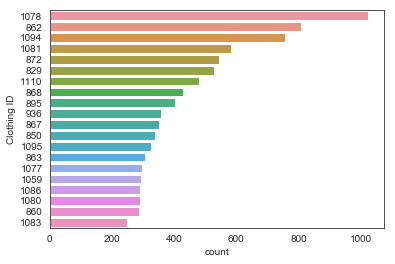

In [26]:
num = 20
#f, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.countplot(y=data_clean['Clothing ID'], \
              order=data_clean['Clothing ID'].value_counts().iloc[:num].index)

Top 20 best selling products (averaged rating also high (above 4)) Top 10 Best Selling Products (counts) [936, 868, 895, 1110, 829, 872, 1081, 1094, 862, 1078]
The best selling is 1078 (dress).  

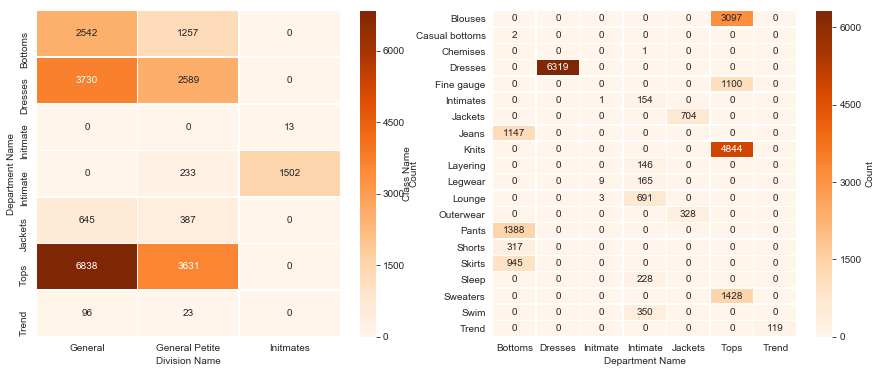

In [27]:
f, ax = plt.subplots(1, 2, figsize=(15, 6))
fsize = 13
sns.heatmap(pd.crosstab(data_clean['Department Name'], data_clean['Division Name']),
            annot=True, linewidths=.5, ax=ax[0], fmt='g', cmap='Oranges',
            cbar_kws={'label': 'Count'})

sns.heatmap(pd.crosstab(data_clean['Class Name'], data_clean['Department Name']),
            annot=True, linewidths=.5, ax=ax[1], fmt='g', cmap='Oranges',
            cbar_kws={'label': 'Count'})

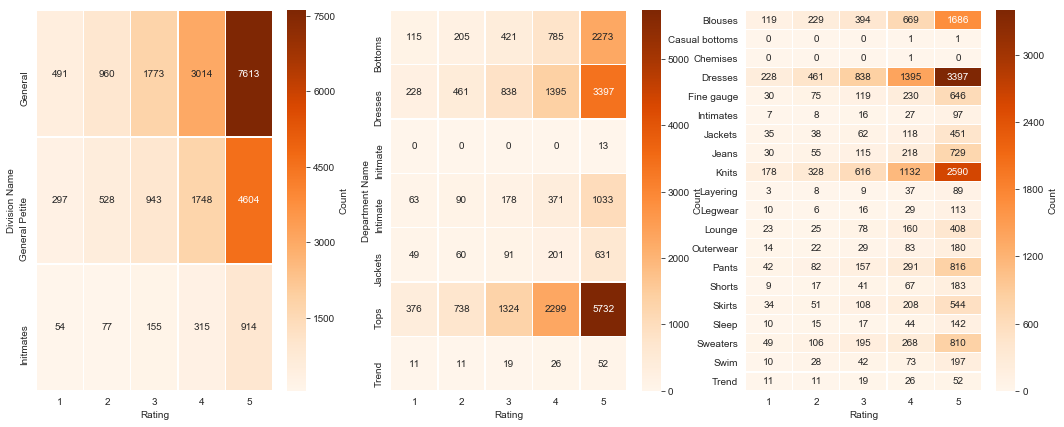

In [28]:
#data.groupby(['Rating','Recommended IND']).mean()['Positive Feedback Count']
f, ax = plt.subplots(1, 3, figsize=(18, 7))
fsize = 13
sns.heatmap(pd.crosstab(data_clean['Division Name'],data_clean['Rating']),
            annot=True, linewidths=.5, ax=ax[0], fmt='g', cmap='Oranges',
            cbar_kws={'label': 'Count'})

sns.heatmap(pd.crosstab(data_clean['Department Name'],data_clean['Rating']),
            annot=True, linewidths=.5, ax=ax[1], fmt='g', cmap='Oranges',
            cbar_kws={'label': 'Count'})


sns.heatmap(pd.crosstab(data_clean['Class Name'],data_clean['Rating']),
            annot=True, linewidths=.5, fmt='g', cmap='Oranges',
            cbar_kws={'label': 'Count'},ax=ax[2])

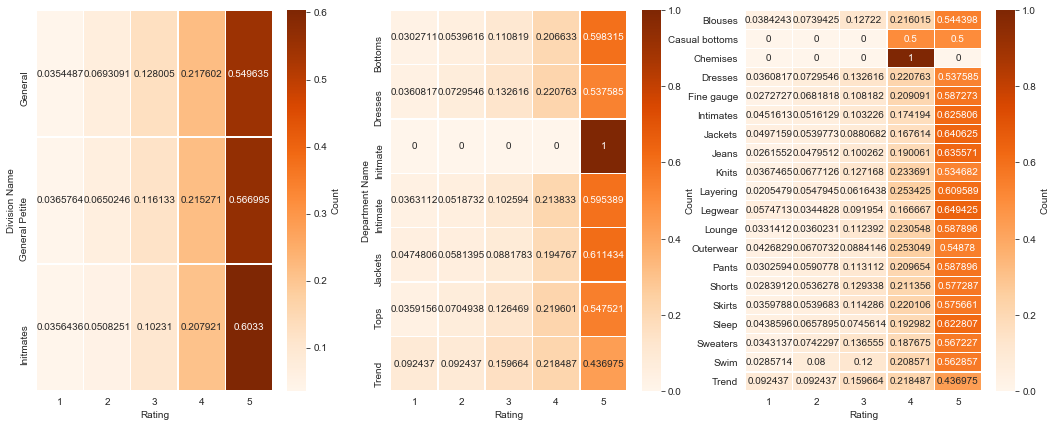

In [29]:
#data.groupby(['Rating','Recommended IND']).mean()['Positive Feedback Count']
f, ax = plt.subplots(1, 3, figsize=(18, 7))
fsize = 13
sns.heatmap(pd.crosstab(data_clean['Division Name'],data_clean['Rating'],normalize = 'index'),
            annot=True, linewidths=.5, ax=ax[0], fmt='g', cmap='Oranges',
            cbar_kws={'label': 'Count'})

sns.heatmap(pd.crosstab( data_clean['Department Name'],data_clean['Rating'],normalize = 'index'),
            annot=True, linewidths=.5, ax=ax[1], fmt='g', cmap='Oranges',
            cbar_kws={'label': 'Count'})


sns.heatmap(pd.crosstab(data_clean['Class Name'],data_clean['Rating'],normalize = 'index'),
            annot=True, linewidths=.5, fmt='g', cmap='Oranges',
            cbar_kws={'label': 'Count'},ax=ax[2])

General, General Petite have similar rating percent. Intimate sells very well. Dresses sell very well. 

### Text data: customer reviews & titles
Sentiment and Recommendation classification


In [30]:
data_clean.groupby(['Recommended IND']).describe()['Text Length']

,count,mean,std,min,25%,50%,75%,max
Recommended IND,,,,,,,,
0,4172.0,60.963806,27.916380,1.0,39.0,60.0,88.0,115.0
1,19314.0,57.441079,30.525055,1.0,32.0,56.0,87.0,115.0


In [31]:
data_clean.groupby(['Rating']).describe()['Text Length']

,count,mean,std,min,25%,50%,75%,max
Rating,,,,,,,,
1,842.0,57.195962,28.440410,1.0,35.0,55.0,82.75,111.0
2,1565.0,61.432588,27.502106,1.0,39.0,61.0,88.00,110.0
3,2871.0,63.161268,28.318930,1.0,40.0,63.0,92.00,115.0
4,5077.0,61.241678,30.364973,1.0,37.0,62.0,92.00,113.0
5,13131.0,55.380169,30.488136,1.0,30.0,53.0,84.00,115.0


In [32]:
data_nlp = data_clean[data_clean['Rating'] !=3] # remove neutrak ratings equal 3

In [33]:
data_nlp['Positively Rated'] = np.where(data_nlp['Rating'] > 3, 1,0) # if >3 positive 
pd.crosstab(data_nlp['Recommended IND'], data_nlp['Positively Rated'])

/Users/hanzhang/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Positively Rated,0,1
Recommended IND,,
0,2297,193
1,110,18015


## Build the WordCloud from reviews and titles

In [34]:
words_dist_review=clothing_text(data_nlp['Review Text']).word_freq()  # review 
words_dist_title=clothing_text(data_nlp['Title']).word_freq()    # title

In [35]:
del words_dist_title['none'] # remove the none 

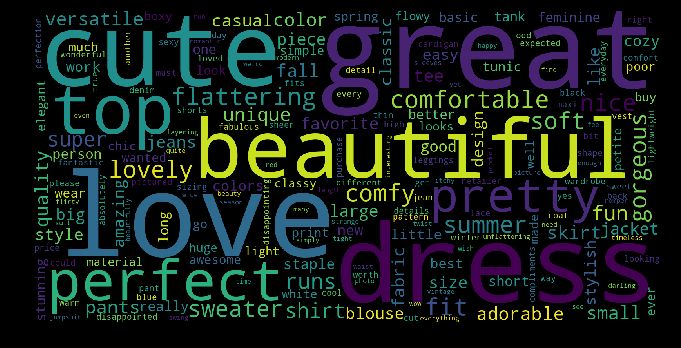

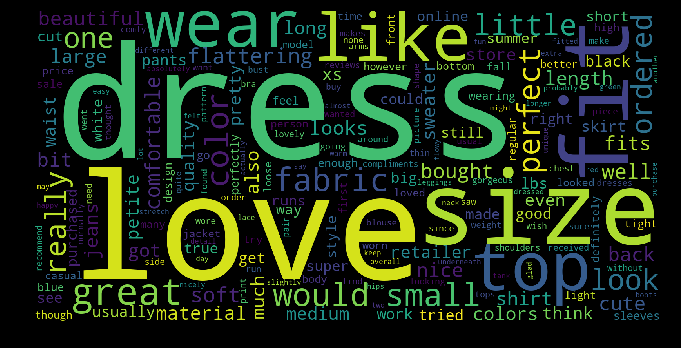

In [36]:
plot_cloud(words_dist_title,size = (15,5))
plot_cloud(words_dist_review,size = (15,5))

Dress is the popular product of the company. 

In [37]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [38]:
No_Recommend = data_clean['Review Text'][data_clean['Recommended IND']==0]
Recommend = data_clean['Review Text'][data_clean['Recommended IND']==1]

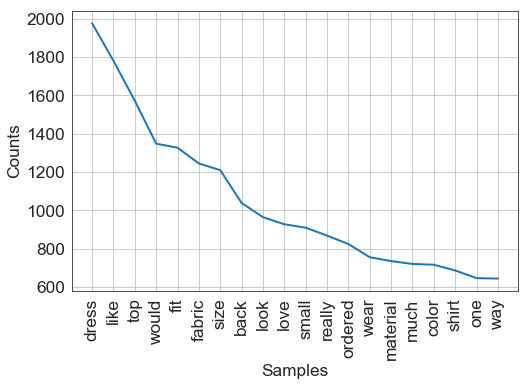

In [39]:
clothing_text(No_Recommend).word_freq().plot(20,cumulative=False)

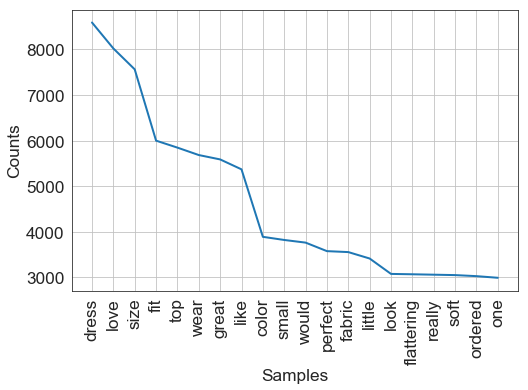

In [40]:
clothing_text(Recommend).word_freq().plot(20,cumulative=False)

### Pre-processing
Text data tokenization and normalization

In [41]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for col in ['Division Name','Department Name','Class Name']:
    data_nlp[col] = le.fit_transform(data_nlp[col])

/Users/hanzhang/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [42]:
data_nlp.columns

Index(['Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name', 'Text Length', 'Positively Rated'],
      dtype='object')

In [43]:
X=data_nlp.drop(columns=['Positively Rated'])
y=data_nlp['Positively Rated']

In [44]:
# split the dataset for classification test size 0.3 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=101)

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(min_df=5,ngram_range=(1,3)).fit(X_train['Review Text']) # convert to matrix
X_train_vectorized = vect.transform(X_train['Review Text'])
X_test_vectorized = vect.transform(X_test['Review Text'])

In [46]:
print('Shape of Sparse Matrix: ', X_train_vectorized.shape)
print('Amount of Non-Zero occurences: ', X_train_vectorized.nnz)

Shape of Sparse Matrix:  (14430, 41091)
Amount of Non-Zero occurences:  1341231


### Models 

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from nltk.classify import NaiveBayesClassifier
from sklearn.metrics import confusion_matrix,classification_report

1. Logistic Regression

In [48]:
LR=LogisticRegression(penalty='l1',C=2.5)
LR.fit(X_train_vectorized,y_train)
predictions = LR.predict(X_test_vectorized)

kfold = KFold(n_splits=5, shuffle=True, random_state=0)
result_LR= cross_val_score(LR, X_train_vectorized, y_train, \
                                   cv=kfold,scoring='roc_auc')
print('Cross Validation '+'Logistic Regression',np.mean(result_LR))
print('AUC:',roc_auc_score(y_test,predictions))

Cross Validation Logistic Regression 0.9438909759808294
AUC: 0.8007234885327243


In [49]:
feature_names=np.array(vect.get_feature_names())
sorted_coef_index=LR.coef_[0].argsort()
small=list(feature_names[sorted_coef_index[:10]])
large=list(feature_names[sorted_coef_index[-11:-1]])
print(small)
print(large)

['comfortable however', 'poor', 'killer', 'awful', 'not recommend', 'not thick', 'very disappointed', 'weirdly', 'worst', 'happening']
['but the sizing', '145', 'when first', '34dd', 'not too', 'prefer', 'sure would', 'stunning', 'upper arms', 'pleased']


In [50]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.72      0.63      0.67       728
          1       0.95      0.97      0.96      5457

avg / total       0.92      0.93      0.93      6185



2. Naive Bayes

In [51]:
# Naive Bayes method 
nb = MultinomialNB()
nb.fit(X_train_vectorized,y_train)
predictions = nb.predict(X_test_vectorized)

result_NB= cross_val_score(nb, X_train_vectorized, y_train, \
                                   cv=kfold,scoring='roc_auc')
print('Cross Validation '+'Naive Bayes',np.mean(result_NB))
print('AUC:',roc_auc_score(y_test,predictions))

Cross Validation Naive Bayes 0.9578580474724003
AUC: 0.8886757255022785


In [52]:
X_train_f=add_feature(X_train_vectorized, [X_train['Age'],X_train['Division Name'],\
                                           X_train['Department Name'],X_train['Class Name']])
X_test_f=add_feature(X_test_vectorized, [X_test['Age'],X_test['Division Name'],\
                                        X_test['Department Name'],X_test['Class Name']])

In [53]:
LR=LogisticRegression(penalty='l1',C=2.5)
LR.fit(X_train_f,y_train)
predictions = LR.predict(X_test_f)
result_LR= cross_val_score(LR, X_train_f, y_train, \
                                   cv=kfold,scoring='roc_auc')
print(result_LR.mean())
print('AUC:',roc_auc_score(y_test,predictions))

0.9438458569056948
AUC: 0.8045240562076735


In [54]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.73      0.64      0.68       728
          1       0.95      0.97      0.96      5457

avg / total       0.93      0.93      0.93      6185



3. LinearSVC

In [55]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X_train_vectorized, y_train) 
predictions = clf.predict(X_test_vectorized)
result_svm= cross_val_score(clf, X_train_vectorized, y_train, \
                                   cv=kfold,scoring='roc_auc')
print(result_svm.mean())
print('AUC:',roc_auc_score(y_test,predictions))

0.9459094227536315
AUC: 0.805806057146079


While, it seems including other features does not help much (also tried NB method).

 include TF-IDF to this process using a pipeline.

In [56]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('bow', TfidfVectorizer(min_df=5,ngram_range=(1,3))),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [57]:
pipeline.fit(X_train['Review Text'],y_train)

Pipeline(memory=None,
     steps=[('bow', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
   ...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [58]:
predictions = pipeline.predict(X_test['Review Text'])
print('AUC:',roc_auc_score(y_test,predictions))

AUC: 0.5281593406593407


TF-IDF does not work very well. I guess it is because all these words are common used. 

### Recommendation 

In [59]:
X=data_clean.drop(columns=['Recommended IND'])
y=data_clean['Recommended IND']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=101)

In [60]:
vect = CountVectorizer(analyzer=text_process,min_df=5,ngram_range=(1,3)).fit(X_train['Review Text']) # convert to matrix
X_train_vectorized = vect.transform(X_train['Review Text'])
X_test_vectorized = vect.transform(X_test['Review Text'])

In [61]:
print('Shape of Sparse Matrix: ', X_train_vectorized.shape)
print('Amount of Non-Zero occurences: ', X_train_vectorized.nnz)

Shape of Sparse Matrix:  (16440, 3995)
Amount of Non-Zero occurences:  403084


1. Logistic Regression

In [62]:
LR=LogisticRegression(penalty='l1',C=3)
LR.fit(X_train_vectorized,y_train)
predictions = LR.predict(X_test_vectorized)

kfold = KFold(n_splits=5, shuffle=True, random_state=0)
result_LR= cross_val_score(LR, X_train_vectorized, y_train, \
                                   cv=kfold,scoring='roc_auc')
print('Cross Validation '+'Logistic Regression',np.mean(result_LR))
print('AUC:',roc_auc_score(y_test,predictions))

Cross Validation Logistic Regression 0.882768108482562
AUC: 0.7670716055693221


2. NaiveBayes

In [63]:
# Naive Bayes method 
nb = MultinomialNB()
nb.fit(X_train_vectorized,y_train)
predictions = nb.predict(X_test_vectorized)
result_NB= cross_val_score(nb, X_train_vectorized, y_train, \
                                   cv=kfold,scoring='roc_auc')
print('Cross Validation '+'Naive Bayes',np.mean(result_NB))
print('AUC:',roc_auc_score(y_test,predictions))

Cross Validation Naive Bayes 0.9208420163264129
AUC: 0.8209638527441023


In [64]:
feature_names=np.array(vect.get_feature_names())
sorted_coef_index=nb.coef_[0].argsort()
small=list(feature_names[sorted_coef_index[:20]])
large=list(feature_names[sorted_coef_index[-21:-1]])
print(small)
print(large)

['rag', 'protrude', 'coarse', 'fooled', 'ginormous', 'altering', 'defective', 'upside', 'laugh', 'choking', 'halloween', 'remotely', 'weirdly', 'joke', 'disliked', 'steer', 'impractical', 'include', 'bizarre', 'lacking']
['one', 'ordered', 'soft', 'look', 'flattering', 'really', 'little', 'fabric', 'perfect', 'would', 'small', 'color', 'im', 'like', 'great', 'wear', 'top', 'fit', 'size', 'love']


In [65]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[ 900  340]
 [ 487 5319]]
             precision    recall  f1-score   support

          0       0.65      0.73      0.69      1240
          1       0.94      0.92      0.93      5806

avg / total       0.89      0.88      0.89      7046



### Summary:
Applied Logistic Regression, Naive Bayes, and SVC for the sentiment and recommendation analysis with 90% accuracy. Understanding customer reviews is important to improve customer services and prioritize product updates. For this company, on average, the feedback from customers are pretty good and especially, the company has built a reputation for their dresses. 